# 1D Motion

### **Introduction**

We live in a quite complex world, where motion is considered a synonym of life. In fact, everything we do is related to motion. 

Our world is composed of 3 dimensions (3D) in which you can move (jump, run, swim, do backflips, etc.). In this lab, we will explore only a part of that complexity of the world we live in - Motion in a single dimension. 


### **What is it?**
What is this type of Motion and why should we study it? Well first, 1D motion is a motion of an object in a straight line. The reason to study this physics topic is to understand the topic of motion. As was mentioned previously, our world comprises 3 dimensions. Why do we start from only one? The thing is, even 1D motion is able to tell us useful information and help to derive certain physical and mathematical principles. 


### **Example**
Electric supercar manufacturer Rimac claimed the acceleration record from a still position hitting 400 km/h and dropping down to 0 in 29.93 seconds. Later on, the engineers of Koenigsegg (probably) took that record personally and made a car that can do 0-400-0 km/h in just 27.83 seconds.

The interesting moment is how the cars were moving when they were beating one record after another. They were mimicking the trajectory of a line.

Although as was said many times previously, our world is 3 dimensional. While we think the car moves in a line, it is also subjected to the gravitation that acts on objects in the vertical dimension (perpendicular to a car). So we can't really do a 1D motion on our planet without utilizing special instruments. In simulations nevertheless, we can enable the dimensions we want.

### **What types of motion exist?**

There are:

- Uniform Motion
- Non-Uniform Motion

Here, we will study the first type of motion, which consists of:

- Uniform Motion
- Uniformly Accelerated Motion
- Uniformly Decelerated Motion

The figure below shows those types of motion:

<img src="../../media/Linear Motion.png" />

### **Formulas**

Motion might be calculated using the following formulas:

Velocity: $\vec{v}=\vec{v_0}+\vec{a}t$\
Position: $x=x_0+\vec{v}t+\frac{1}{2}\vec{a}t^2$

Velocity and position have an interesting realtion. We may derive velocity by taking the derivative from position and derive position by integrating the velocity (which you could learn at Calculus):

* $\vec{v} =\frac{dx}{dt}$
* $x = \int{\vec{v}}dt$ 

# Simulation

### Installing packages (for Google Colab)

If this notebook is opened in Google Colab then some packages must be installed to run the code!

In [1]:
#@title Run to install MuJoCo and `dm_control` for Google Colab

IS_COLAB = 'google.colab' in str(get_ipython())

if IS_COLAB:
    import distutils.util
    import os
    import subprocess
    if subprocess.run('nvidia-smi').returncode:
        raise RuntimeError(
            'Cannot communicate with GPU. '
            'Make sure you are using a GPU Colab runtime. '
            'Go to the Runtime menu and select Choose runtime type.')

    # Add an ICD config so that glvnd can pick up the Nvidia EGL driver.
    # This is usually installed as part of an Nvidia driver package, but the Colab
    # kernel doesn't install its driver via APT, and as a result the ICD is missing.
    # (https://github.com/NVIDIA/libglvnd/blob/master/src/EGL/icd_enumeration.md)
    NVIDIA_ICD_CONFIG_PATH = '/usr/share/glvnd/egl_vendor.d/10_nvidia.json'
    if not os.path.exists(NVIDIA_ICD_CONFIG_PATH):
        with open(NVIDIA_ICD_CONFIG_PATH, 'w') as f:
            f.write("""{
            "file_format_version" : "1.0.0",
            "ICD" : {
                "library_path" : "libEGL_nvidia.so.0"
            }
        }
        """)

    print('Installing dm_control...')
    !pip install -q dm_control>=1.0.22

    # Configure dm_control to use the EGL rendering backend (requires GPU)
    %env MUJOCO_GL=egl 

    print('Checking that the dm_control installation succeeded...')
    try:
        from dm_control import suite
        env = suite.load('cartpole', 'swingup')
        pixels = env.physics.render()
    except Exception as e:
        raise e from RuntimeError(
            'Something went wrong during installation. Check the shell output above '
            'for more information.\n'
            'If using a hosted Colab runtime, make sure you enable GPU acceleration '
            'by going to the Runtime menu and selecting "Choose runtime type".')
    else:
        del pixels, suite

    !echo Installed dm_control $(pip show dm_control | grep -Po "(?<=Version: ).+")

    # Graphics and plotting.
    print('Installing mediapy:')
    !command -v ffmpeg >/dev/null || (apt update && apt install -y ffmpeg)
    !pip install -q mediapy

    !git clone https://github.com/commanderxa/extraphi.git

## Import

Import all required packages to preform simulations. Packages include simulation engine, plotting libraries and other ones necessary for computations.

In [2]:
%env MUJOCO_GL=egl

# simulation
from dm_control import mjcf

# for video recording
import mediapy

# computations
import numpy as np

# plot charts
import seaborn as sns
import matplotlib.pyplot as plt

env: MUJOCO_GL=egl


Set nice theme for plots

In [3]:
sns.set_theme(style="whitegrid")

## Initial Conditions

In this block constants are defined. They impact the environment, rendering and objects directly.

**Note**, don't set very high values for velocity as the simulation might crash. If you will experience such a situation, try reducing the velocity!

In [4]:
# global
viscosity = 0  # Air Resistance

# simulation constants
# inital velocity [m/s]
v = 10
# acceleration [m/s^2]
a = -1

size = 0.3
platform_length = 500

# rendering
width = 1280
height = 720
dpi = 600
duration = 10  # (seconds)
framerate = 60  # (Hz)

## Model

### Scene

Import scene from `mechanics/scene.py`. The code is a bit difficult due to the import from parent directories.

In [5]:
if not IS_COLAB:
  import os, sys

  module_path = os.path.abspath(os.path.join(".."))
  if module_path not in sys.path:
      sys.path.append(module_path)

  from scene import Scene

else:
  from extraphi.mechanics.scene import Scene

### Objects of Interest

Here we create all the objects that will interact in the world. To model `1D motion` one might create a moving box.

In [6]:
class Box(object):

    def __init__(self, size: float) -> None:
        self.model = mjcf.RootElement(model="box")

        self.box = self.model.worldbody.add("body", name="box", pos=[0, 0, 0])
        self.box_geom = self.box.add(
            "geom",
            name="box_geom",
            type="box",
            size=[size * 2, size, size],
            mass=1,
            rgba=[1, 0, 0, 1],
            condim=1,
        )

        self.camera = self.box.add(
            "camera",
            name="front",
            pos=[0, -4, 1],
            euler=[75, 0, 0],
            mode="track",
            fovy=45,
        )

        self.move = self.box.add("joint", name="move", type="slide", axis=[1, 0, 0])
        self.fall = self.box.add("joint", name="fall", type="slide", axis=[0, 0, 1])

### World Model

Collecting everything into one general model: Scene and Object. Here, we also may set certain attributes for the MuJoCo engine, for example `viscosity` and `integrator`. 

In [7]:
class Model(object):

    def __init__(self, size: float, platform_length: float) -> None:
        self.model = mjcf.RootElement(model="model")

        # set render info
        self.model.visual.__getattr__("global").offheight = height
        self.model.visual.__getattr__("global").offwidth = width
        self.model.visual.map.znear = 0.001

        # set the simulation constants
        self.model.option.viscosity = viscosity
        self.model.option.integrator = "RK4"
        self.model.option.timestep = 0.001

        # create the scene (ground)
        self.scene = Scene(length=platform_length, width=2)
        self.scene_site = self.model.worldbody.add(
            "site", pos=[platform_length / 2 - size * 2, 0, 0]
        )
        self.scene_site.attach(self.scene.model)

        # add the object
        self.box = Box(size)
        box_site = self.model.worldbody.add(
            "site",
            pos=[
                platform_length / 2 + -platform_length / 2,
                0,
                size / 2 + 0.1,
            ],
        )
        box_site.attach(self.box.model)

## Simulation

Initializing the `physics` of the simulation

In [8]:
model = Model(size, platform_length).model
physics = mjcf.Physics.from_mjcf_model(model)

First of all, the environment must be verified by rendering a picture

""

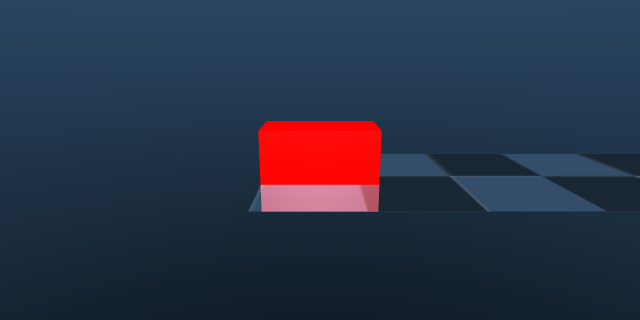

In [9]:
mediapy.show_image(physics.render(height=320, width=640, camera_id=0))

### Simulation Loop

In [10]:
frames = []
timevals = []
velocity = []
position = []

physics.named.data.qvel["box/move"] = v
physics.step()

while physics.data.time < duration:
    physics.step()
    
    # applying the acceleration specifier in `a`
    physics.named.data.qvel["box/move"] += a * physics.model.opt.timestep

    # we can obtain certain properties of the objects and thw world,
    # here we writing the time of the step, velocity and position of the `box`
    timevals.append(physics.data.time)
    velocity.append(physics.named.data.qvel["box/move"][0].copy())
    position.append(physics.named.data.geom_xpos["box/box_geom"][0].copy())

    if len(frames) < physics.data.time * framerate:
        pixels = physics.render(width=width, height=height, camera_id=0)
        frames.append(pixels)

In [11]:
# Simulate and display video.
mediapy.show_video(frames, fps=framerate)

Save the rendered video

In [12]:
m_type = "acceleration" if a > 0 else "deceleration"
if a == 0:
    m_type = "constant"

video_name = f"1d_motion_{m_type}.mp4" if IS_COLAB else f"../../output/1d_motion.mp4"
mediapy.write_video(video_name, images=frames, fps=framerate)

## Simulation Data Visualization

Collected velocities and position now can be plotted to investigate what happened to the object.

Convert data into numpy array to have more features

In [13]:
velocity = np.array(velocity)
position = np.array(position)

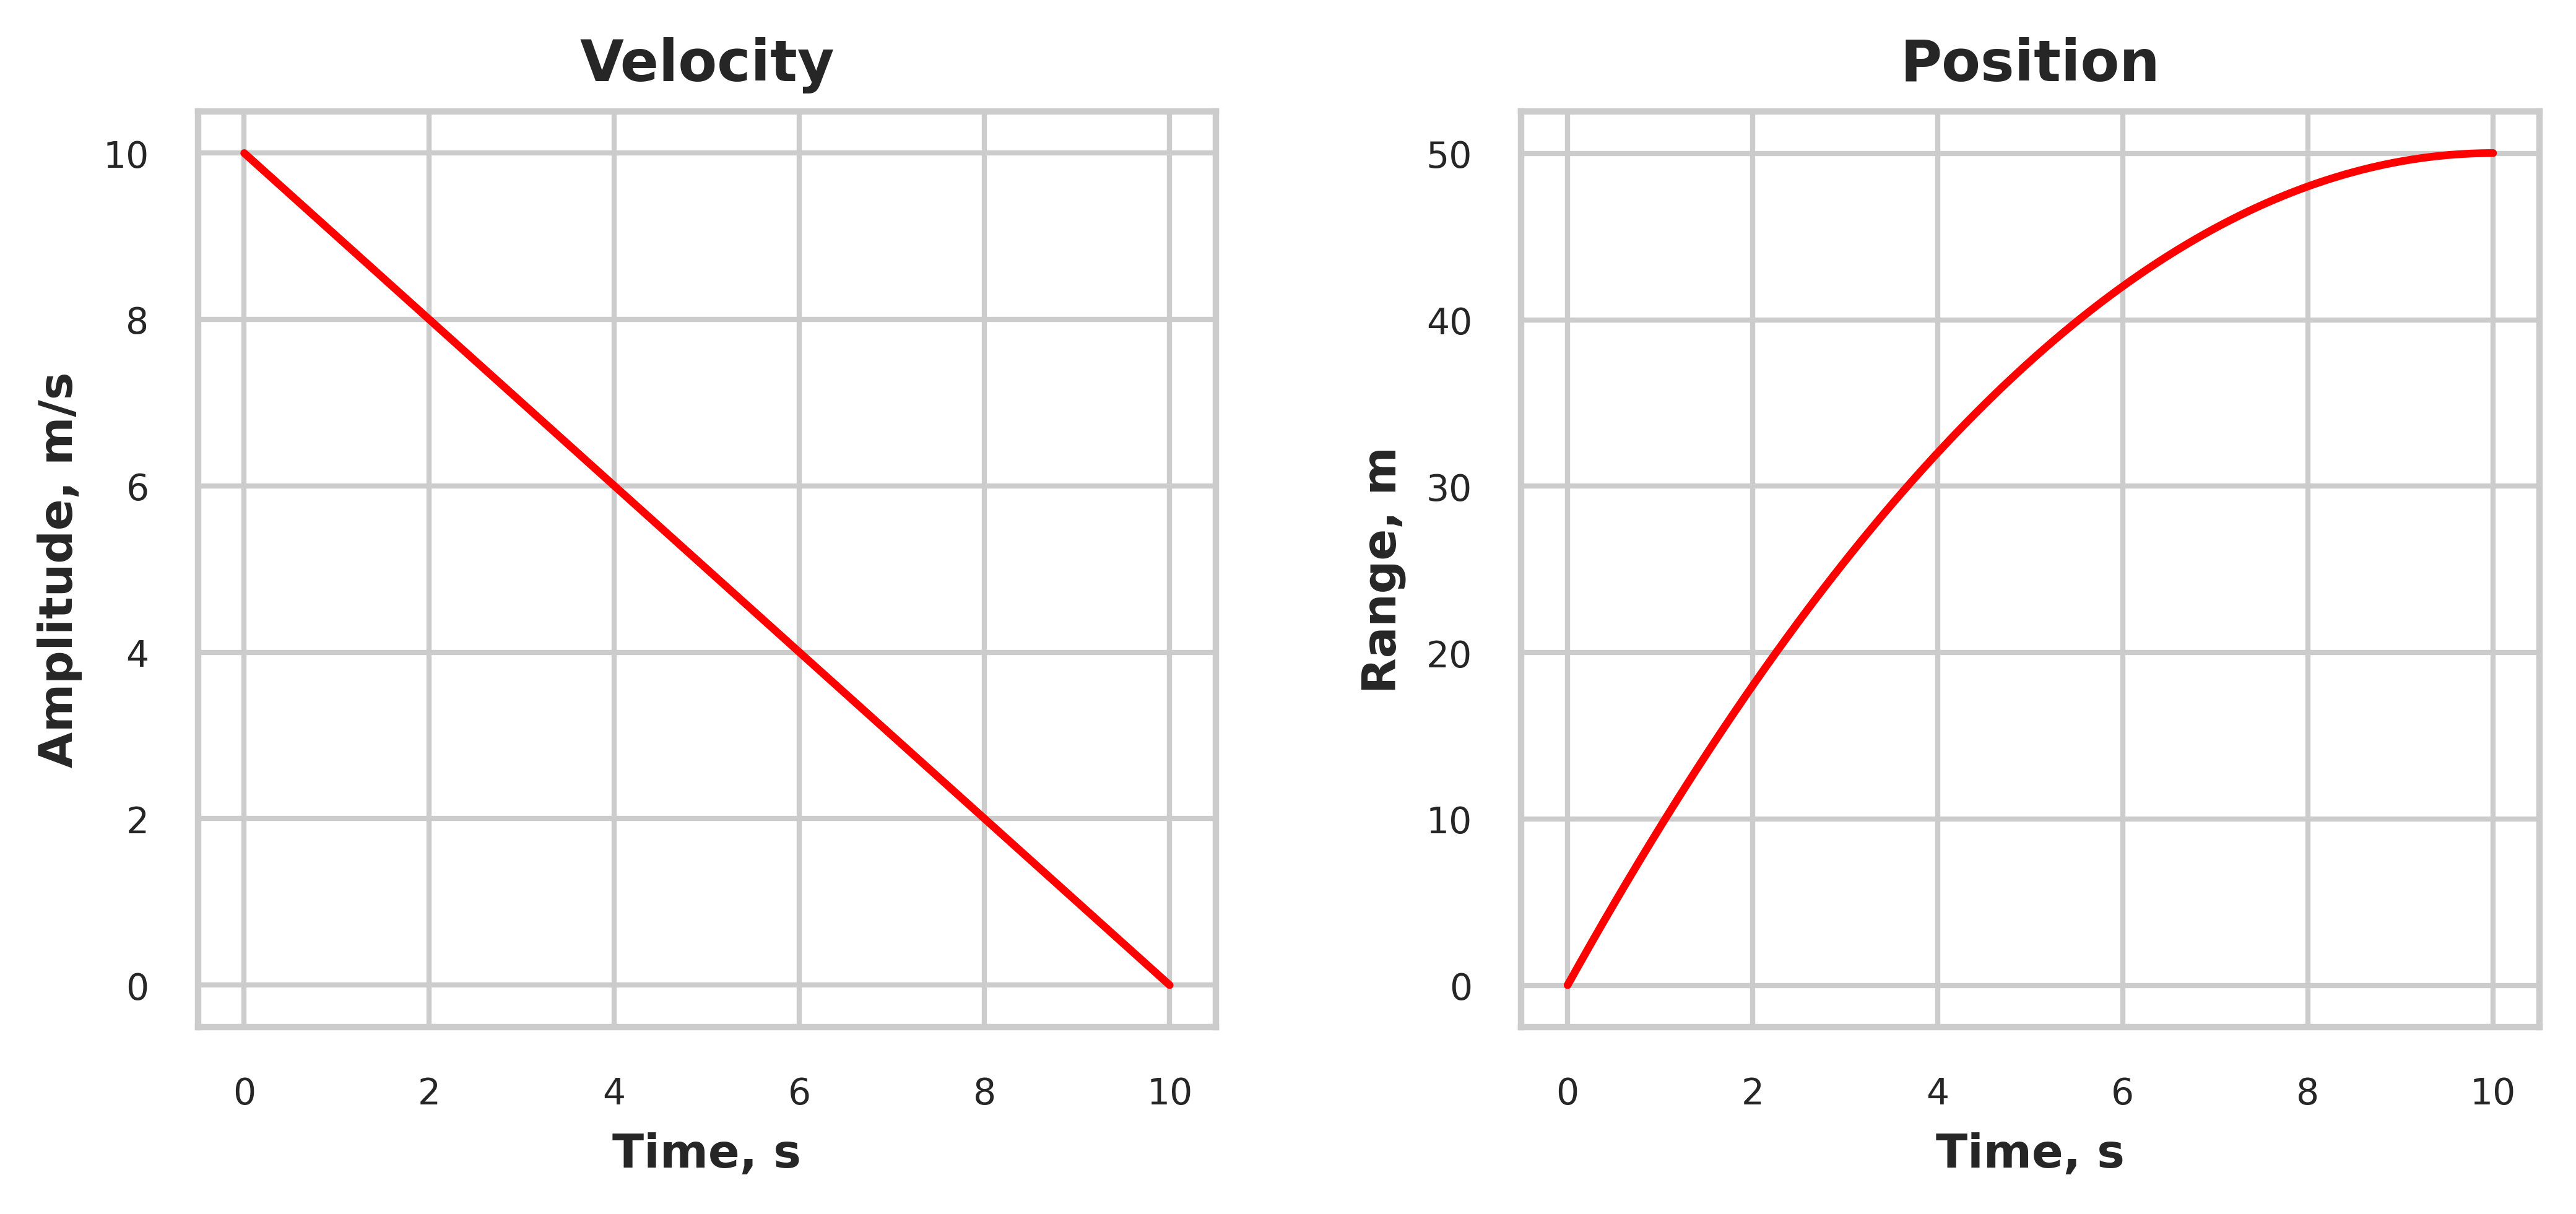

In [14]:
figsize = (width / dpi + 6, height / dpi + 2)
fig, ax = plt.subplots(ncols=2, figsize=figsize, dpi=dpi, sharex=False)
fig.subplots_adjust(wspace=0.3)

# position
sns.lineplot(x=timevals, y=position, ax=ax[1], color="red")
ax[1].set_title("Position", weight="bold", fontsize=11)
ax[1].set_ylabel("Range, m", weight="bold", fontsize=9)
ax[1].set_xlabel("Time, s", weight="bold", fontsize=9)
ax[1].tick_params(labelsize=7)

# velocity
sns.lineplot(x=timevals, y=velocity, ax=ax[0], color="red")
ax[0].set_title("Velocity", weight="bold", fontsize=11)
ax[0].set_ylabel("Amplitude, m/s", weight="bold", fontsize=9)
ax[0].set_xlabel("Time, s", weight="bold", fontsize=9)
ax[0].tick_params(labelsize=7)

chart_name = f"1d_motion_{m_type}.png" if IS_COLAB else f"../../output/1d_motion.png"
fig.savefig(chart_name, bbox_inches="tight")

In [15]:
velocity[-1], position[-1]

(np.float64(1.0259154636926837e-13), np.float64(50.015000000002786))